In [2]:
import pandas as pd
data = pd.read_csv('DataCoSupplyChainDataset.csv',encoding_errors='ignore').head(1000)

In [3]:
data.shape

(1000, 53)

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LeaveOneOut



# Feature Selection
features = ['Sales per customer', 'Days for shipping (real)', 'Days for shipment (scheduled)',
            'Benefit per order', 'Late_delivery_risk', 'Order Item Discount',
            'Order Item Discount Rate', 'Order Item Product Price', 'Order Item Profit Ratio',
            'Sales', 'Order Item Total', 'Order Profit Per Order', 'Customer Segment',
            'Shipping Mode']

# Numerical Features for Imputation
numerical_features = ['Sales per customer', 'Days for shipping (real)', 'Days for shipment (scheduled)',
                      'Benefit per order', 'Late_delivery_risk', 'Order Item Discount',
                      'Order Item Discount Rate', 'Order Item Product Price', 'Order Item Profit Ratio',
                      'Sales', 'Order Item Total', 'Order Profit Per Order']

In [5]:
# Impute Negative Values
for feature in numerical_features:
    if data[feature].lt(0).any():
        median_value = data[feature].median()
        data.loc[data[feature] < 0, feature] = median_value

# Check for Negative Values
negative_values = data[numerical_features].lt(0).sum()
print("Negative values in each feature:")
print(negative_values)

# Data Preprocessing
data['order_date'] = pd.to_datetime(data['order date (DateOrders)'])
data['year'] = data['order_date'].dt.year
data['month'] = data['order_date'].dt.month
data['day_of_week'] = data['order_date'].dt.dayofweek

X = data[features]
X = pd.get_dummies(X)  # Encode categorical variables
y = data['Order Item Quantity']

Negative values in each feature:
Sales per customer               0
Days for shipping (real)         0
Days for shipment (scheduled)    0
Benefit per order                0
Late_delivery_risk               0
Order Item Discount              0
Order Item Discount Rate         0
Order Item Product Price         0
Order Item Profit Ratio          0
Sales                            0
Order Item Total                 0
Order Profit Per Order           0
dtype: int64


Original dataset shape: 1    415
5    293
4    167
3     70
2     55
Name: Order Item Quantity, dtype: int64
Resampled dataset shape: [  0 339 339 339 339 339]


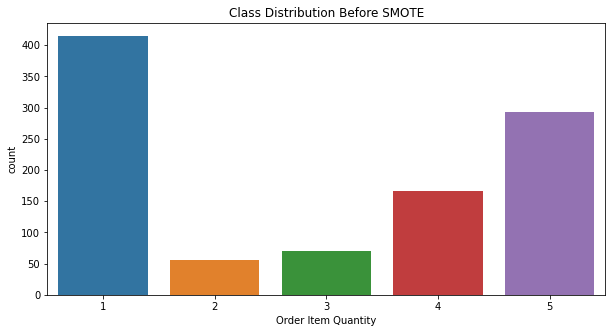

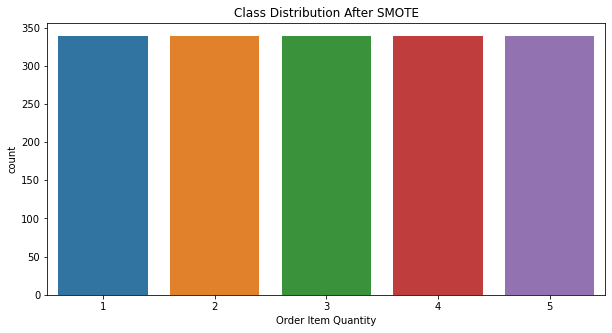

In [6]:
# Split the Data Before SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE on Training Data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original dataset shape:", y.value_counts())
print("Resampled dataset shape:", np.bincount(y_train_resampled))

# Visualize Class Distribution Before SMOTE and After SMOTE
plt.figure(figsize=(10, 5))
sns.countplot(x=y)
plt.title('Class Distribution Before SMOTE')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x=y_train_resampled)
plt.title('Class Distribution After SMOTE')
plt.show()

In [7]:
# Models Initialization and Regularization(to avoid overfitting)
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42),
    "SVM": SVC(C=1.0, probability=True, random_state=42) 
}

In [8]:
# Evaluate Models
for model_name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(report)
    print("="*60)

Model: Random Forest
Accuracy: 0.9500
Confusion Matrix:
[[76  0  0  0  0]
 [ 0 12  0  0  0]
 [ 0  0 12  0  2]
 [ 0  0  1 28  1]
 [ 0  0  1  5 62]]
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        12
           3       0.86      0.86      0.86        14
           4       0.85      0.93      0.89        30
           5       0.95      0.91      0.93        68

    accuracy                           0.95       200
   macro avg       0.93      0.94      0.94       200
weighted avg       0.95      0.95      0.95       200

Model: Gradient Boosting
Accuracy: 0.9900
Confusion Matrix:
[[75  1  0  0  0]
 [ 0 12  0  0  0]
 [ 0  0 14  0  0]
 [ 0  0  0 29  1]
 [ 0  0  0  0 68]]
Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.99      0.99        76
           2       0.92      1.00      0.96        12
    

## LEARNING CURVE TO VISUALIZE THE performance of a model as a function

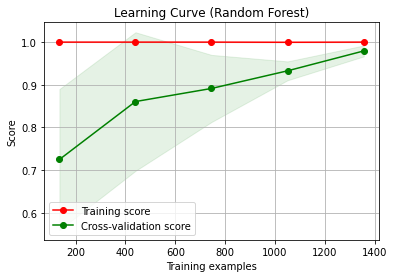

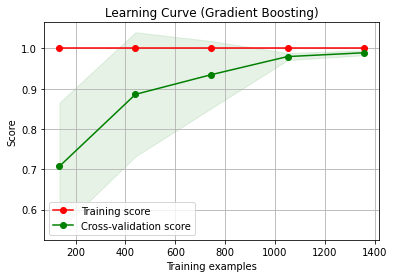

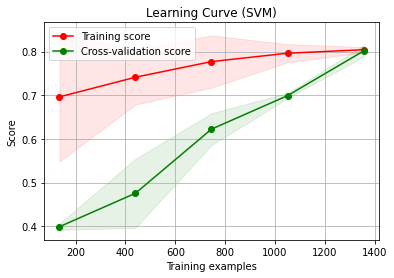

In [9]:
# Function to plot the learning curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
for model_name, model in models.items():
    plot_learning_curve(model, f'Learning Curve ({model_name})', X_train_resampled, y_train_resampled, cv=5, n_jobs=-1)
    plt.show()

## ERROR ANALYSIS

In [10]:
def error_analysis(model, X_test, y_test):
    y_pred = model.predict(X_test)
    errors = np.where(y_pred != y_test)[0]
    print(f"Total number of errors: {len(errors)}")
    if len(errors) > 0:
        error_df = pd.DataFrame({'True Label': y_test.iloc[errors].values, 'Predicted Label': y_pred[errors]})
        print(error_df)

    return errors

for model_name, model in models.items():
    print(f"Error Analysis for {model_name}")
    errors = error_analysis(model, X_test, y_test)
    print("="*60)

Error Analysis for Random Forest
Total number of errors: 10
   True Label  Predicted Label
0           4                5
1           3                5
2           5                3
3           5                4
4           3                5
5           5                4
6           5                4
7           5                4
8           4                3
9           5                4
Error Analysis for Gradient Boosting
Total number of errors: 2
   True Label  Predicted Label
0           1                2
1           4                5
Error Analysis for SVM
Total number of errors: 33
    True Label  Predicted Label
0            5                3
1            1                2
2            5                4
3            3                2
4            5                4
5            3                4
6            5                3
7            5                4
8            4                3
9            5                3
10           5                3
11       

## Function to perform LOOCV and calculate metrics

In [11]:
def perform_loocv(model, X, y):
    loo = LeaveOneOut()
    y_true = []
    y_pred = []
    confidence_scores = []

    iteration = 1
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Make the prediction
        prediction = model.predict(X_test)[0]
        y_pred.append(prediction)
        y_true.append(y_test.values[0])

        # Get the confidence score for the predicted class
        confidence = model.predict_proba(X_test)[0].max()  # Adjusted to fetch max probability
        confidence_scores.append(confidence)

        # Print the prediction and confidence score with iteration number
        print(f"Iteration: {iteration}, True: {y_test.values[0]}, Predicted: {prediction}, Confidence: {confidence:.4f}")
        iteration += 1

    # Calculate the overall metrics
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    average_confidence = np.mean(confidence_scores)
    std_confidence = np.std(confidence_scores)

    return accuracy, cm, report, average_confidence, std_confidence

print("\nGradient Boosting LOOCV Results:")
gb_accuracy, gb_cm, gb_report, gb_avg_conf, gb_std_conf = perform_loocv(models["Gradient Boosting"], X_train_resampled, y_train_resampled)

# Print Gradient Boosting LOOCV results
print("\nGradient Boosting LOOCV Results")
print(f"LOOCV Accuracy: {gb_accuracy:.4f}")
print("LOOCV Confusion Matrix:")
print(gb_cm)
print("LOOCV Classification Report:")
print(gb_report)
print(f"Average Confidence Score: {gb_avg_conf:.4f}")
print(f"Standard Deviation of Confidence Scores: {gb_std_conf:.4f}")


Gradient Boosting LOOCV Results:
Iteration: 1, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 2, True: 5, Predicted: 5, Confidence: 0.9947
Iteration: 3, True: 5, Predicted: 5, Confidence: 0.9978
Iteration: 4, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 5, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 6, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 7, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 8, True: 5, Predicted: 5, Confidence: 0.9978
Iteration: 9, True: 4, Predicted: 4, Confidence: 0.9824
Iteration: 10, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 11, True: 3, Predicted: 3, Confidence: 0.9916
Iteration: 12, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 13, True: 5, Predicted: 5, Confidence: 0.9982
Iteration: 14, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 15, True: 5, Predicted: 5, Confidence: 0.9952
Iteration: 16, True: 2, Predicted: 2, Confidence: 0.9996
Iteration: 17, True: 5, Predicted: 5, Confidence: 0.9964
Iterat

Iteration: 144, True: 5, Predicted: 5, Confidence: 0.9979
Iteration: 145, True: 1, Predicted: 1, Confidence: 1.0000
Iteration: 146, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 147, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 148, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 149, True: 3, Predicted: 3, Confidence: 0.9993
Iteration: 150, True: 5, Predicted: 5, Confidence: 0.9982
Iteration: 151, True: 1, Predicted: 1, Confidence: 0.9930
Iteration: 152, True: 5, Predicted: 5, Confidence: 0.9971
Iteration: 153, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 154, True: 3, Predicted: 3, Confidence: 0.9974
Iteration: 155, True: 5, Predicted: 5, Confidence: 0.7177
Iteration: 156, True: 5, Predicted: 5, Confidence: 0.9979
Iteration: 157, True: 5, Predicted: 5, Confidence: 0.9981
Iteration: 158, True: 1, Predicted: 1, Confidence: 1.0000
Iteration: 159, True: 2, Predicted: 2, Confidence: 0.9996
Iteration: 160, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 161

Iteration: 286, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 287, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 288, True: 2, Predicted: 2, Confidence: 0.9996
Iteration: 289, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 290, True: 4, Predicted: 4, Confidence: 0.9958
Iteration: 291, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 292, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 293, True: 4, Predicted: 4, Confidence: 0.9958
Iteration: 294, True: 5, Predicted: 5, Confidence: 0.9953
Iteration: 295, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 296, True: 1, Predicted: 1, Confidence: 0.9930
Iteration: 297, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 298, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 299, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 300, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 301, True: 5, Predicted: 4, Confidence: 0.4953
Iteration: 302, True: 1, Predicted: 1, Confidence: 0.9938
Iteration: 303

Iteration: 428, True: 5, Predicted: 5, Confidence: 0.9981
Iteration: 429, True: 5, Predicted: 5, Confidence: 0.9979
Iteration: 430, True: 4, Predicted: 4, Confidence: 0.9976
Iteration: 431, True: 5, Predicted: 5, Confidence: 0.9980
Iteration: 432, True: 4, Predicted: 4, Confidence: 0.8991
Iteration: 433, True: 5, Predicted: 5, Confidence: 0.9965
Iteration: 434, True: 5, Predicted: 5, Confidence: 0.9873
Iteration: 435, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 436, True: 4, Predicted: 4, Confidence: 0.9957
Iteration: 437, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 438, True: 5, Predicted: 5, Confidence: 0.9981
Iteration: 439, True: 1, Predicted: 1, Confidence: 1.0000
Iteration: 440, True: 5, Predicted: 5, Confidence: 0.9988
Iteration: 441, True: 1, Predicted: 1, Confidence: 1.0000
Iteration: 442, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 443, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 444, True: 5, Predicted: 5, Confidence: 0.9980
Iteration: 445

Iteration: 570, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 571, True: 4, Predicted: 4, Confidence: 0.9962
Iteration: 572, True: 5, Predicted: 5, Confidence: 0.7435
Iteration: 573, True: 5, Predicted: 5, Confidence: 0.9982
Iteration: 574, True: 5, Predicted: 5, Confidence: 0.9978
Iteration: 575, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 576, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 577, True: 5, Predicted: 5, Confidence: 0.9980
Iteration: 578, True: 2, Predicted: 2, Confidence: 0.9989
Iteration: 579, True: 1, Predicted: 1, Confidence: 0.9992
Iteration: 580, True: 4, Predicted: 4, Confidence: 0.9790
Iteration: 581, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 582, True: 1, Predicted: 1, Confidence: 1.0000
Iteration: 583, True: 5, Predicted: 5, Confidence: 0.9965
Iteration: 584, True: 1, Predicted: 1, Confidence: 1.0000
Iteration: 585, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 586, True: 4, Predicted: 4, Confidence: 0.9951
Iteration: 587

Iteration: 712, True: 4, Predicted: 4, Confidence: 0.9886
Iteration: 713, True: 5, Predicted: 5, Confidence: 0.9969
Iteration: 714, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 715, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 716, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 717, True: 5, Predicted: 5, Confidence: 0.9979
Iteration: 718, True: 5, Predicted: 5, Confidence: 0.9979
Iteration: 719, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 720, True: 3, Predicted: 3, Confidence: 0.9976
Iteration: 721, True: 4, Predicted: 4, Confidence: 0.9960
Iteration: 722, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 723, True: 4, Predicted: 4, Confidence: 0.9462
Iteration: 724, True: 4, Predicted: 4, Confidence: 0.9979
Iteration: 725, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 726, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 727, True: 1, Predicted: 1, Confidence: 1.0000
Iteration: 728, True: 3, Predicted: 3, Confidence: 0.9986
Iteration: 729

Iteration: 854, True: 2, Predicted: 2, Confidence: 0.9984
Iteration: 855, True: 2, Predicted: 2, Confidence: 0.9997
Iteration: 856, True: 2, Predicted: 2, Confidence: 0.9994
Iteration: 857, True: 2, Predicted: 2, Confidence: 0.9995
Iteration: 858, True: 2, Predicted: 2, Confidence: 0.9998
Iteration: 859, True: 2, Predicted: 2, Confidence: 0.9996
Iteration: 860, True: 2, Predicted: 2, Confidence: 0.9996
Iteration: 861, True: 2, Predicted: 2, Confidence: 0.9984
Iteration: 862, True: 2, Predicted: 2, Confidence: 0.9998
Iteration: 863, True: 2, Predicted: 2, Confidence: 0.9998
Iteration: 864, True: 2, Predicted: 2, Confidence: 0.9996
Iteration: 865, True: 2, Predicted: 2, Confidence: 0.9998
Iteration: 866, True: 2, Predicted: 2, Confidence: 0.9995
Iteration: 867, True: 2, Predicted: 2, Confidence: 0.9998
Iteration: 868, True: 2, Predicted: 2, Confidence: 0.9995
Iteration: 869, True: 2, Predicted: 2, Confidence: 0.9998
Iteration: 870, True: 2, Predicted: 2, Confidence: 0.9997
Iteration: 871

Iteration: 996, True: 2, Predicted: 2, Confidence: 0.9996
Iteration: 997, True: 2, Predicted: 2, Confidence: 0.9996
Iteration: 998, True: 2, Predicted: 2, Confidence: 0.9996
Iteration: 999, True: 2, Predicted: 2, Confidence: 0.9993
Iteration: 1000, True: 2, Predicted: 2, Confidence: 0.9998
Iteration: 1001, True: 2, Predicted: 2, Confidence: 0.9996
Iteration: 1002, True: 2, Predicted: 2, Confidence: 0.9993
Iteration: 1003, True: 2, Predicted: 2, Confidence: 0.9959
Iteration: 1004, True: 2, Predicted: 2, Confidence: 0.9995
Iteration: 1005, True: 2, Predicted: 2, Confidence: 0.9982
Iteration: 1006, True: 2, Predicted: 2, Confidence: 0.9994
Iteration: 1007, True: 2, Predicted: 2, Confidence: 0.9998
Iteration: 1008, True: 2, Predicted: 2, Confidence: 0.9998
Iteration: 1009, True: 2, Predicted: 2, Confidence: 0.9996
Iteration: 1010, True: 2, Predicted: 2, Confidence: 0.9994
Iteration: 1011, True: 2, Predicted: 2, Confidence: 0.9999
Iteration: 1012, True: 2, Predicted: 2, Confidence: 0.9996
I

Iteration: 1135, True: 3, Predicted: 3, Confidence: 0.9949
Iteration: 1136, True: 3, Predicted: 3, Confidence: 0.9983
Iteration: 1137, True: 3, Predicted: 3, Confidence: 0.9974
Iteration: 1138, True: 3, Predicted: 3, Confidence: 0.9976
Iteration: 1139, True: 3, Predicted: 3, Confidence: 0.9993
Iteration: 1140, True: 3, Predicted: 3, Confidence: 0.9959
Iteration: 1141, True: 3, Predicted: 3, Confidence: 0.9943
Iteration: 1142, True: 3, Predicted: 3, Confidence: 0.9944
Iteration: 1143, True: 3, Predicted: 3, Confidence: 0.9911
Iteration: 1144, True: 3, Predicted: 3, Confidence: 0.9928
Iteration: 1145, True: 3, Predicted: 3, Confidence: 0.9978
Iteration: 1146, True: 3, Predicted: 3, Confidence: 0.9946
Iteration: 1147, True: 3, Predicted: 3, Confidence: 0.9867
Iteration: 1148, True: 3, Predicted: 3, Confidence: 0.9913
Iteration: 1149, True: 3, Predicted: 3, Confidence: 0.9986
Iteration: 1150, True: 3, Predicted: 3, Confidence: 0.9987
Iteration: 1151, True: 3, Predicted: 3, Confidence: 0.99

Iteration: 1274, True: 3, Predicted: 3, Confidence: 0.9976
Iteration: 1275, True: 3, Predicted: 3, Confidence: 0.9908
Iteration: 1276, True: 3, Predicted: 3, Confidence: 0.9901
Iteration: 1277, True: 3, Predicted: 3, Confidence: 0.9608
Iteration: 1278, True: 3, Predicted: 3, Confidence: 0.9972
Iteration: 1279, True: 3, Predicted: 3, Confidence: 0.9964
Iteration: 1280, True: 3, Predicted: 3, Confidence: 0.9904
Iteration: 1281, True: 3, Predicted: 3, Confidence: 0.9974
Iteration: 1282, True: 3, Predicted: 3, Confidence: 0.9972
Iteration: 1283, True: 3, Predicted: 3, Confidence: 0.9965
Iteration: 1284, True: 3, Predicted: 3, Confidence: 0.9751
Iteration: 1285, True: 3, Predicted: 3, Confidence: 0.9993
Iteration: 1286, True: 3, Predicted: 3, Confidence: 0.9931
Iteration: 1287, True: 3, Predicted: 3, Confidence: 0.9797
Iteration: 1288, True: 3, Predicted: 3, Confidence: 0.9957
Iteration: 1289, True: 3, Predicted: 3, Confidence: 0.9939
Iteration: 1290, True: 3, Predicted: 3, Confidence: 0.99

Iteration: 1413, True: 4, Predicted: 4, Confidence: 0.9940
Iteration: 1414, True: 4, Predicted: 4, Confidence: 0.9947
Iteration: 1415, True: 4, Predicted: 4, Confidence: 0.9968
Iteration: 1416, True: 4, Predicted: 4, Confidence: 0.7127
Iteration: 1417, True: 4, Predicted: 4, Confidence: 0.9971
Iteration: 1418, True: 4, Predicted: 4, Confidence: 0.9965
Iteration: 1419, True: 4, Predicted: 4, Confidence: 0.9963
Iteration: 1420, True: 4, Predicted: 4, Confidence: 0.9967
Iteration: 1421, True: 4, Predicted: 4, Confidence: 0.9971
Iteration: 1422, True: 4, Predicted: 4, Confidence: 0.9874
Iteration: 1423, True: 4, Predicted: 4, Confidence: 0.9971
Iteration: 1424, True: 4, Predicted: 4, Confidence: 0.9799
Iteration: 1425, True: 4, Predicted: 4, Confidence: 0.9907
Iteration: 1426, True: 4, Predicted: 4, Confidence: 0.9958
Iteration: 1427, True: 4, Predicted: 4, Confidence: 0.9971
Iteration: 1428, True: 4, Predicted: 4, Confidence: 0.9953
Iteration: 1429, True: 4, Predicted: 4, Confidence: 0.99

Iteration: 1552, True: 4, Predicted: 4, Confidence: 0.9963
Iteration: 1553, True: 4, Predicted: 4, Confidence: 0.9905
Iteration: 1554, True: 4, Predicted: 4, Confidence: 0.9909
Iteration: 1555, True: 4, Predicted: 4, Confidence: 0.9962
Iteration: 1556, True: 4, Predicted: 4, Confidence: 0.9850
Iteration: 1557, True: 4, Predicted: 4, Confidence: 0.7976
Iteration: 1558, True: 4, Predicted: 4, Confidence: 0.9970
Iteration: 1559, True: 4, Predicted: 4, Confidence: 0.9969
Iteration: 1560, True: 4, Predicted: 4, Confidence: 0.9968
Iteration: 1561, True: 4, Predicted: 4, Confidence: 0.9968
Iteration: 1562, True: 4, Predicted: 4, Confidence: 0.9962
Iteration: 1563, True: 4, Predicted: 4, Confidence: 0.9956
Iteration: 1564, True: 4, Predicted: 4, Confidence: 0.9897
Iteration: 1565, True: 4, Predicted: 4, Confidence: 0.9959
Iteration: 1566, True: 4, Predicted: 4, Confidence: 0.9954
Iteration: 1567, True: 4, Predicted: 4, Confidence: 0.9970
Iteration: 1568, True: 4, Predicted: 4, Confidence: 0.99

Iteration: 1691, True: 5, Predicted: 5, Confidence: 0.9985
Iteration: 1692, True: 5, Predicted: 5, Confidence: 0.9980
Iteration: 1693, True: 5, Predicted: 5, Confidence: 0.9981
Iteration: 1694, True: 5, Predicted: 5, Confidence: 0.9982
Iteration: 1695, True: 5, Predicted: 5, Confidence: 0.9977

Gradient Boosting LOOCV Results
LOOCV Accuracy: 0.9929
LOOCV Confusion Matrix:
[[338   1   0   0   0]
 [  0 337   2   0   0]
 [  0   1 338   0   0]
 [  0   0   1 335   3]
 [  0   0   0   4 335]]
LOOCV Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       339
           2       0.99      0.99      0.99       339
           3       0.99      1.00      0.99       339
           4       0.99      0.99      0.99       339
           5       0.99      0.99      0.99       339

    accuracy                           0.99      1695
   macro avg       0.99      0.99      0.99      1695
weighted avg       0.99      0.99      0.99   